In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.util import random_noise

from keras import layers, metrics

In [2]:
IMAGE_CHANNELS = 3

IMAGE_HEIGHT =  192 #194 # 636 # 388 # 256
IMAGE_WIDTH = 64 # 70 # 229 # 140 # 128

In [3]:
seed = 4
np.random.seed = seed
random.seed(seed)

DATA_TRAIN = "./datasets/KolektorSDD2/train/"
DATA_TEST = "./datasets/KolektorSDD2/test/"



train_ids = next(os.walk(os.path.join(DATA_TRAIN, "images/")))[2]
test_ids = next(os.walk(os.path.join(DATA_TEST, "images/")))[2]

damaged = []
damaged_mask = []
X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

# __author__ = "Sreenivas Bhattiprolu"
# __license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# # Credits https://github.com/bnsreenu/python_for_microscopists 

# """
# @author: Sreenivas Bhattiprolu
# """

print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = DATA_TRAIN # + id_

    img = imread(path + 'images/' + id_)[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    X_train[n] = img  #Fill empty X_train with values from img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]
    
    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0     
    mask = mask.astype(np.bool_) 
    mask = mask.astype(np.float16)  
    y_train[n] = mask 

    if np.count_nonzero(mask) != 0:
        damaged.append(img)
        damaged_mask.append(mask)


    
# test images
test_images = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
test_masks = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = DATA_TEST
    img = imread(path + '/images/' + id_ )[:,:,:IMAGE_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    test_images[n] = img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0     
    mask = mask.astype(np.bool_) 
    mask = mask.astype(np.float16)  
    test_masks[n] = mask 



print('Done!')

Resizing training images and masks


  0%|          | 0/2332 [00:00<?, ?it/s]

100%|██████████| 2332/2332 [01:20<00:00, 28.85it/s]


Resizing test images


100%|██████████| 1004/1004 [00:34<00:00, 29.27it/s]

Done!


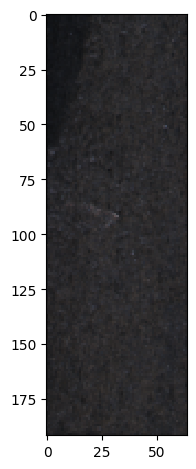

In [4]:
imshow(damaged[1])
plt.show()

In [5]:
non_zero = np.count_nonzero(y_train)
print(non_zero)
# print(non_zero/(IMAGE_HEIGHT*IMAGE_WIDTH*len(y_train))*100)

unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))
print("Percentage of faulty images in train data:", counts[1]/(counts[0]+counts[1])*100, " %")
neg = counts[0]
pos = counts[1]

117581
{0.0: 28538035, 1.0: 117581}
Percentage of faulty images in train data: 0.4103244543757147  %


Bounding Box

In [6]:
Boxes = []
for img in y_train:
    if np.count_nonzero(img) != 0:
        print(type(img))
        print(img)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1]
        cont = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in cont:
            x,y,h,w = cv2.boundingRect(cnt)
            cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 3)
            cv2.imshow("lololol", img)
            cv2.waitKey(0)
            Boxes.append((x,y,w,h))

<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1659: error: (-210:Unsupported format or combination of formats)  in function 'cv::threshold'


Augmentation

In [13]:
vertical_train = np.flip(damaged, axis=0)
vertical_test = np.flip(damaged_mask, axis=0)

horizontal_train = np.flip(damaged, axis=1)
horizontal_test = np.flip(damaged_mask, axis=1)

rotating_train = np.rot90(damaged, k=2)
rotating_test = np.rot90(damaged_mask, k=2)

vert_rot_train = np.rot90(vertical_train, k=2)
vert_rot_test = np.rot90(vertical_test, k=2)

hor_rot_train = np.rot90(horizontal_train, k=2)
hor_rot_test = np.rot90(horizontal_test, k=2)

Add Noise

In [28]:
noised = np.empty_like(damaged)
noised_mask = damaged_mask
for img in damaged:
    i = 0
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised[i] = noise
    i = i+1

noised_vert = np.empty_like(damaged)
noised_mask_vert = vertical_test
for img in vertical_train:
    i = 0
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised_vert[i] = noise
    i = i+1

noised_horr = np.empty_like(damaged)
noised_mask_horr = horizontal_test
for img in horizontal_train:
    i = 0
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised_horr[i] = noise
    i = i+1

In [27]:
print(np.shape(damaged))
print(np.shape(noised))

(247, 192, 64, 3)
(247, 192, 64, 3)


In [29]:
X_train = np.concatenate((vertical_train, horizontal_train, rotating_train, vert_rot_train, hor_rot_train, X_train, noised, noised_vert, noised_horr))
y_train = np.concatenate((vertical_test, horizontal_test, rotating_test, vert_rot_test, hor_rot_test, y_train, noised_mask, noised_mask_vert, noised_mask_horr))

In [30]:
print(X_train.shape)

(4308, 192, 64, 3)
